In [1]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import get_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)

## Problem Definition

## Dataset
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

Section contents:
- Visualize random sample
- Calculate dataset statistics

In [2]:
dataset_name = "librispeech"
dataset = get_dataset(dataset_name)

You're about to download librispeech with url dev-clean

 Done downloading


#### Visualizing data in random sample

waveform:  tensor([[0.0002, 0.0005, 0.0005,  ..., 0.0047, 0.0081, 0.0127]])
sample_rate:  16000
transcript:  HE MUST HAVE DRAWN HIS GUN BECAUSE THE INTRUDER SAID QUICKLY PUT THAT AWAY YOU'RE BEING A FOOL OUT
speaker_id:  1272


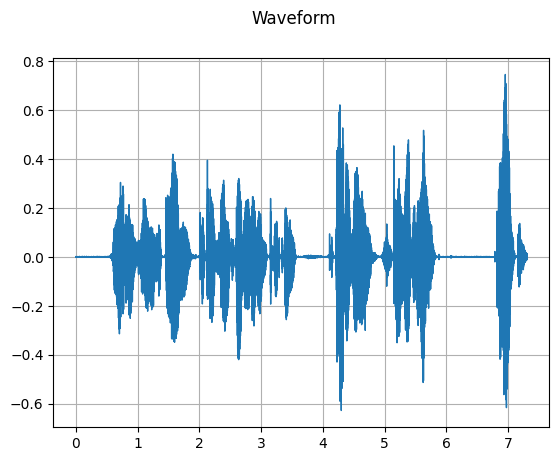

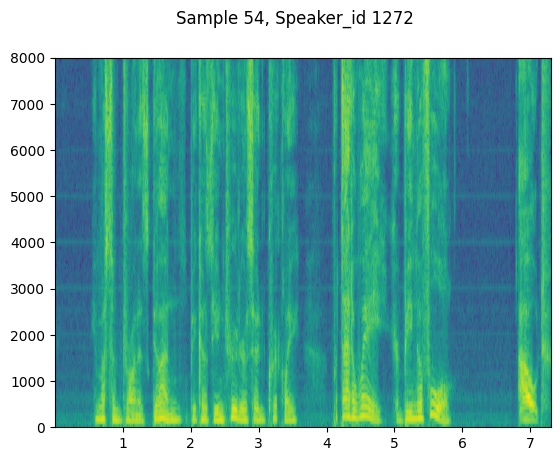

In [3]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [4]:
# waveform_lengths = []
# sample_rates = []
# transcript_lengths = []
# speaker_ids = []
# audio_durations = []    

# for i in range(dataset.__len__()):
#     (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
#     waveform_lengths.append(waveform[0].shape[0])
#     sample_rates.append(sample_rate)
#     transcript_lengths.append(len(transcript))
#     speaker_ids.append(speaker_id)

#     num_channels, num_frames = waveform.shape
#     duration = num_frames / sample_rate
#     audio_durations.append(duration)

# dataset_stats = pd.DataFrame.from_dict(
# {
#     "waveform_lengths" : waveform_lengths,
#     "sample_rates" : sample_rates,
#     "transcript_lengths" : transcript_lengths,
#     "audio_durations" : audio_durations,
# }
#     )

In [5]:
# df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
# df_spkr['speaker_id'] = speaker_ids
# df_spkr['duration'] = audio_durations

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset

In [6]:
# df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Number of samples for each speaker

In [7]:
# df_spkr.groupby('speaker_id').size().sort_values()

In [8]:
# df = calculate_statistics(dataset)

## Preprocessing

In [9]:
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.70
val_pct = 0.20
test_pct = 0.10
number_spectral_coeffients = 13

We decided to normalize our data by using the mean and variance of the amplitude. The normalizer is fitted on the whole training set, not for each speaker. The reasoning for this is that in our problem, we do not know ahead of time who the speaker is.

In [18]:
def split_waveform(waveform : np.array, window_size : int) -> list[np.array]:
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waverforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

def split_train_test_val(mfcc_dataset, train_pct, val_pct, test_pct):
    x = np.asarray(mfcc_dataset.mfcc_speaker_pairs)[:,0]
    y = np.asarray(mfcc_dataset.mfcc_speaker_pairs)[:,1]
    x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=val_pct+test_pct, train_size=train_pct, shuffle=True)
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=test_pct/(val_pct+test_pct), train_size=val_pct/(val_pct+test_pct), shuffle=True)

    
    train_pairs = [[x_train[i], y_train[i]] for i in range(len(x_train))]
    val_pairs = [[x_val[i], y_val[i]] for i in range(len(x_val))]
    test_pairs = [[x_test[i], y_test[i]] for i in range(len(x_test))]
            
    return train_pairs, val_pairs, test_pairs

class CepstralNormalization:
    def __init__(self, number_spectral_coeffients : int):
        """
        """
        self.number_spectral_coeffients = number_spectral_coeffients
        self.mfcc_dataset = None
        self.mfcc_mean : list[float] | None = None
        self.mfcc_std : list[float] | None = None
    
    def fit(self, mfcc_dataset):
        """
        """
        columns = [f"x_{i}" for i in range(self.number_spectral_coeffients)]
        df_coeffs = pd.DataFrame(columns=columns)

        mfcc_mean = []
        mfcc_std = []

        j = 0
        for mfcc, _ in mfcc_dataset:
            for i in range(self.number_spectral_coeffients):
                df_coeffs.loc[j, f"x_{i}"] = mfcc[i,:]
            j += 1

        for i in range(self.number_spectral_coeffients):
            mfcc_mean.append(np.mean(np.hstack(df_coeffs[f"x_{i}"])))
            mfcc_std.append(np.std(np.hstack(df_coeffs[f"x_{i}"])))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return 
    
    def transform(self, mfcc_dataset):
        """
        """
        mfcc_dataset_copy = copy.deepcopy(mfcc_dataset)
        mfcc_speaker_pairs = np.array(mfcc_dataset_copy.mfcc_speaker_pairs)
        
        for sample in mfcc_speaker_pairs:
            for i in range(13):
                sample[0][i,:] = (sample[0][i,:] - self.mfcc_mean[i]) / self.mfcc_std[i]
        
        mfcc_dataset_copy.mfcc_speaker_pairs = mfcc_speaker_pairs
        
        return mfcc_dataset_copy

class MFCCData(Dataset):
    def __init__(self, dataset, window_size : int, sample_rate : int):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        train_test_val : str
            one of 'train', 'validation', or 'test'
        """
        self.dataset = dataset
        self.window_size = window_size        
        self.sample_rate = sample_rate
        
        self.transform_to_mfcc()

    def transform_to_mfcc(self):
        """
        Transforms waveforms into MFCC spectrograms
        """
        self.mfcc_speaker_pairs = []
        
        for i in range(self.dataset.__len__()):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = self.dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, self.window_size)
            
            for chunk in splitted_waveform:
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=self.sample_rate)
                self.mfcc_speaker_pairs.append([mfccs, speaker_id])
            
    def __len__(self):
        return len(self.mfcc_speaker_pairs)

    def __getitem__(self, idx):
        waveform = self.mfcc_speaker_pairs[idx][0]
        speaker_id = self.mfcc_speaker_pairs[idx][1]
        return waveform, speaker_id

In [23]:
def get_datasets(base_dataset, window_size : int, sample_rate : int, train_pct : float, val_pct : float, test_pct : float, number_spectral_coeffients : int):
    """
    """
    try:
        mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = torch.load(f'mfcc_dataset_train_{train_pct}.pt'), torch.load(f'mfcc_dataset_val_{val_pct}.pt'), torch.load(f'mfcc_dataset_test_{test_pct}.pt') 
    
    except FileNotFoundError:
        mfcc_dataset = MFCCData(base_dataset, window_size=window_size, sample_rate=sample_rate)

        train_pairs, val_pairs, test_pairs = split_train_test_val(mfcc_dataset, train_pct, val_pct, test_pct)
        mfcc_dataset_train = copy.deepcopy(mfcc_dataset)
        mfcc_dataset_val = copy.deepcopy(mfcc_dataset)
        mfcc_dataset_test = copy.deepcopy(mfcc_dataset)
        mfcc_dataset_train.mfcc_speaker_pairs = train_pairs
        mfcc_dataset_val.mfcc_speaker_pairs = val_pairs
        mfcc_dataset_test.mfcc_speaker_pairs = test_pairs

        cepstral_normalization = CepstralNormalization(number_spectral_coeffients)

        cepstral_normalization.fit(mfcc_dataset_train)
        mfcc_dataset_train = cepstral_normalization.transform(mfcc_dataset_train)
        mfcc_dataset_val = cepstral_normalization.transform(mfcc_dataset_val)
        mfcc_dataset_test = cepstral_normalization.transform(mfcc_dataset_test)

        torch.save(mfcc_dataset_train, f'mfcc_dataset_train_{train_pct}.pt')
        torch.save(mfcc_dataset_val, f'mfcc_dataset_val_{val_pct}.pt')
        torch.save(mfcc_dataset_test, f'mfcc_dataset_test_{test_pct}.pt')

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [24]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(
                                                            dataset, 
                                                            window_size=window_size, 
                                                            sample_rate=sample_rate, 
                                                            train_pct=train_pct,
                                                            val_pct=val_pct,
                                                            test_pct=test_pct,
                                                            number_spectral_coeffients=number_spectral_coeffients,
                                                            )

/tmp/ipykernel_405781/4099974403.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(mfcc_dataset.mfcc_speaker_pairs)[:,0]
/tmp/ipykernel_405781/4099974403.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.asarray(mfcc_dataset.mfcc_speaker_pairs)[:,1]
/tmp/ipykernel_405781/4099974403.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object'